We write all our import

In [ ]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import imageio
import numpy as np
import os
import math
import tensorflow as tf
from scipy.signal import convolve2d
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import normalizers
import utils
import random as python_random
import os.path
from os import path

* **Local contrast normalisation**

In [ ]:
def LocalNormalization(img, P=3, Q=3, C=1):
    kernel = np.ones((P, Q)) / (P * Q)
    img_mean = convolve2d(img, kernel, boundary='symm', mode='same')
    img_sm = convolve2d(np.square(img), kernel, boundary='symm', mode='same')
    img_std = np.sqrt(np.maximum(img_sm - np.square(img_mean), 0)) + C
    img_ln = (img - img_mean) / img_std
    return img_ln
def computeLCN(images, chemin, bd, cheminSave):
  dataset = []
  for img in (images):
    imgLCN = np.asarray(Image.open(chemin + img))
    mos = [s[1] for s in header_mos if s[0].lower() == (img[0:(img.find('patch') -5)].lower()) or s[0].lower() == (img[0:(img.find('patch') -5)].lower() + '.bmp')]
    imgLCN = cv2.cvtColor(imgLCN,cv2.COLOR_GRAY2RGB) #from gray to RGB
    dataset.append((imgLCN.astype(float)/255.0, mos))
  LCN_mos = np.asarray([s[1][0] for s in dataset]).astype(float)
  LCN_datas = np.asarray([s[0] for s in dataset])
  np.save(cheminSave + 'LCN_mos.npy', LCN_mos.reshape(-1, 1))
  np.save(cheminSave + 'LCN_datas.npy', LCN_datas)

* **Local response normalization**

In [ ]:
LRN = torch.nn.LocalResponseNorm(3)
def LRNColored(img):
  image = np.asarray(img)
  image = image.transpose((2,0,1))
  image_tensor = torch.Tensor(image)
  image_lrn = LRN(image_tensor).numpy().transpose((1,2,0))
  scaled_img = (image_lrn - image_lrn.min())/(image_lrn.max() - image_lrn.min())
  return Image.fromarray(np.uint8(scaled_img * 255) , 'RGB')
def computeLRN(images, chemin, bd, cheminSave):
  dataset = []
  for img in (images):
    imgLRN = np.asarray(Image.open(chemin + img))
    mos = [s[1] for s in header_mos if s[0].lower() == (img[0:(img.find('patch') -5)].lower()) or s[0].lower() == (img[0:(img.find('patch') -5)].lower() + '.bmp')]
    dataset.append((imgLRN.astype(float)/255.0, mos))
  LRN_mos = np.asarray([s[1][0] for s in dataset]).astype(float)
  LRN_datas = np.asarray([s[0] for s in dataset])
  np.save(cheminSave + 'LRN_mos.npy', LRN_mos.reshape(-1, 1))
  np.save(cheminSave + 'LRN_datas.npy', LRN_datas)

* ZCA Whitening Normalization

In [ ]:
def ZCA_whitening(img):  # WORKS W/ WARNINGS : img_cn.astype(np.uint8)
  normalizer = normalizers.Tools()
  # ** 1st - Apply contrast normalization to the image
  img_cn = normalizer.contrast_normalize(img)
  # ** 2nd - Apply ZCA sphering normalization to the image
  img_normalized = normalizer.ZCA_sphere(img_cn)
  return img_normalized
def computeZCA(images, chemin, bd, cheminSave):
  dataset = []
  for img in (images):
    imgZCA = np.asarray(Image.open(chemin + img))
    mos = [s[1] for s in header_mos if s[0].lower() == (img[0:(img.find('patch') -5)].lower()) or s[0].lower() == (img[0:(img.find('patch') -5)].lower() + '.bmp')]
    imgZCA = cv2.cvtColor(imgZCA,cv2.COLOR_GRAY2RGB) #from gray to RGB
    dataset.append((imgZCA.astype(float)/255.0, mos))
  ZCA_mos = np.asarray([s[1][0] for s in dataset]).astype(float)
  ZCA_datas = np.asarray([s[0] for s in dataset])
  np.save(cheminSave + 'ZCA_mos.npy', ZCA_mos.reshape(-1, 1))
  np.save(cheminSave + 'ZCA_datas.npy', ZCA_datas)

* **Low Frequency Subtraction Normalization**

In [ ]:
from tensorflow.python.framework.ops import convert_to_tensor
from numpy.core.fromnumeric import reshape

# ======== NORMALIZATION ========

# Compute normalization of an image
def LFSN(image: tf.Tensor) -> tf.Tensor:
    image = tf.cast(image, tf.float32)
    
    # ** 1st - Conversion in greyscale
    image = tf.image.rgb_to_grayscale(image)

    # ** 2nd - Applying low-pass filter and rescale
    image_low = utils.gaussian_filter(image, 16, 7/6)

    # Downsample image
    image_low = utils.rescale(
        image_low,
        1/4,
        method=tf.image.ResizeMethod.BICUBIC)
    # Upsample image
    image_low = tf.image.resize(
            image_low,
            size=utils.image_shape(image),
            method=tf.image.ResizeMethod.BICUBIC)

    # ** 3rd - Return images substerated from their low-pass filtered images
    image_final = image - tf.cast(image_low, image.dtype)
    #tf.cast(image_final, tf.uint8)
    return image_final
def computeLFS(images, chemin, bd, cheminSave):
  dataset = []
  for img in (images):
    imgLFS = np.asarray(Image.open(chemin + img))
    mos = [s[1] for s in header_mos if s[0].lower() == (img[0:(img.find('patch') -5)].lower()) or s[0].lower() == (img[0:(img.find('patch') -5)].lower() + '.bmp')]
    imgLFS = cv2.cvtColor(imgLFS,cv2.COLOR_GRAY2RGB) #from gray to RGB
    dataset.append((imgLFS.astype(float)/255.0, mos))
  LFS_mos = np.asarray([s[1][0] for s in dataset]).astype(float)
  LFS_datas = np.asarray([s[0] for s in dataset])
  np.save(cheminSave + '_' + bd + '_LFS_mos.npy', LFS_mos.reshape(-1, 1))
  np.save(cheminSave + '_' + bd + '_LFS_datas.npy', LFS_datas)

Mount drive and create folders

In [ ]:
# REMI
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# REMI
#!unzip '/content/drive/MyDrive/Master/Research lab/TID2013.zip' -d '/content/origin_TID2013'
!unzip '/content/drive/MyDrive/Master/Research lab/CSIQ.zip' -d '/content/origin_CSIQ'

In [ ]:
#crée les deux dossiers des bds
#Crée les 5 sous dossiers dans chaque bd
def init_collab():
  bd1 = 'CSIQ'
  bd2 = 'TID2013'
  if path.exists('/content/' + bd1) == False:
    os.mkdir('/content/' + bd1)
  if path.exists('/content/' + bd2) == False:
    os.mkdir('/content/' + bd2)
  if path.exists('/content/' + bd1 + '/patch') == False:
    os.mkdir('/content/' + bd1 + '/patch')
  if path.exists('/content/' + bd1 + '/LRN') == False:
    os.mkdir('/content/' + bd1 + '/LRN')
  if path.exists('/content/' + bd1 + '/LCN') == False:
    os.mkdir('/content/' + bd1 + '/LCN')
  if path.exists('/content/' + bd1 + '/ZCA') == False:
    os.mkdir('/content/' + bd1 + '/ZCA')
  if path.exists('/content/' + bd1 + '/LFS') == False:
    os.mkdir('/content/' + bd1 + '/LFS')
  if path.exists('/content/' + bd2 + '/patch') == False:
    os.mkdir('/content/' + bd2 + '/patch')
  if path.exists('/content/' + bd2 + '/LRN') == False:
    os.mkdir('/content/' + bd2 + '/LRN')
  if path.exists('/content/' + bd2 + '/LCN') == False:
    os.mkdir('/content/' + bd2 + '/LCN')
  if path.exists('/content/' + bd2 + '/ZCA') == False:
    os.mkdir('/content/' + bd2 + '/ZCA')
  if path.exists('/content/' + bd2 + '/LFS') == False:
    os.mkdir('/content/' + bd2 + '/LFS')

Generate patchs

In [ ]:
import logging
logging.getLogger().setLevel(logging.ERROR) #ignore lossy conversion
def crop_img(chemin, img, bd, lfsC):
  imgC = Image.open(chemin + img).convert("RGB")
  imgUC = Image.open(chemin + img).convert('L')
  
  longueur = imgC.size[0] / 64
  largeur = imgC.size[1] / 64
  #imgLCN = Image.fromarray(LocalNormalization(imgUC))
  #imgLRN = LRNColored(imgC)
  imgLFS = tf.keras.utils.save_img(lfsC + img + ".png", LFSN(tf.convert_to_tensor(np.asarray(imgC))).numpy().squeeze(0))
  imgLFS = Image.open(lfsC + img + ".png")
  #imgZCA = Image.fromarray(ZCA_whitening(imgUC))
  for j in range(0,int(largeur)):
    for i in range(0,int(longueur)):
      #patchLRN = imgLRN.crop((i * 64, j * 64, (i+1) * 64, (j+1) * 64))
      #patchLCN = imgLCN.crop((i * 64, j * 64, (i+1) * 64, (j+1) * 64))
      #patchZCA = imgZCA.crop((i * 64, j * 64, (i+1) * 64, (j+1) * 64))
      patchLFS = imgLFS.crop((i * 64, j * 64, (i+1) * 64, (j+1) * 64))
      current = str(i+j*longueur)

      #normalisation 1 avec ce patch
      #patchLCN.convert('L').save("/content/" + bd + "/" + "LCN/" + img + "_patch_" + current + ".png", "PNG")
      
      #normalisation 2 avec ce patch 
      #patchLRN.save("/content/" + bd + "/" + "LRN/" + img + "_patch_" + current + ".png", "PNG")

      #normalisation 3 avec ce patch 
      patchLFS.save("/content/" + bd + "/" + "LFS/" + img + "_patch_" + current + ".png", "PNG")

      #normalisation 4 avec ce patch
      #imageio.imwrite("/content/" + bd + "/" + "ZCA/" + img + "_patch_" + current + ".png", np.asarray(patchZCA))
def launchPatch(chemin, bd, nb):
  init_collab()
  lfsC = '/content/GB/'
  if path.exists('/content/GB') == False:
    os.mkdir('/content/GB')
  images  = [f for f in os.listdir(chemin) if os.path.splitext(f)[-1] == '.png' or os.path.splitext(f)[-1] == '.PNG'  or os.path.splitext(f)[-1] == '.bmp'  or os.path.splitext(f)[-1] == '.BMP']
  if nb > 0:
    for i in range(nb):
      crop_img(chemin, images[i], bd, lfsC)
  else:
    for img in (images):
      crop_img(chemin, img, bd, lfsC)
#launchPatch('/content/origin_TID2013/TID2013/', 'TID2013', 466)
launchPatch('/content/origin_CSIQ/CSIQ/dst_imgs/', 'CSIQ', 466)
#if path.exists('/content/CSIQ/') == True:
  #!zip -r "/content/drive/MyDrive/Master/Research lab/CSIQ_LCNNorm.zip" "/content/CSIQ/LCN"
  #!zip -r "/content/drive/MyDrive/Master/Research lab/CSIQ_LRNNorm.zip" "/content/CSIQ/LRN"
  #!zip -r "/content/drive/MyDrive/Master/Research lab/CSIQ_ZCANorm.zip" "/content/CSIQ/ZCA"
  #!zip -r "/content/drive/MyDrive/Master/Research lab/CSIQ_LFSNorm.zip" "/content/CSIQ/LFS"
if path.exists('/content/TID2013/') == True:
  #!zip -r "/content/drive/MyDrive/Master/Research lab/TID2013_LCNNorm.zip" "/content/TID2013/LCN"
  #!zip -r "/content/drive/MyDrive/Master/Research lab/TID2013_LRNNorm.zip" "/content/TID2013/LRN"
  #!zip -r "/content/drive/MyDrive/Master/Research lab/TID2013_ZCANorm.zip" "/content/TID2013/ZCA"
  !zip -r "/content/drive/MyDrive/Master/Research lab/TID2013_LFSNorm.zip" "/content/TID2013/LFS"

  adding: content/TID2013/LFS/ (stored 0%)


Create the mos based on csv data

In [ ]:
#get csv, extract name of images
if path.exists('/content/drive/MyDrive/Master/Research lab') == True:
  !cp '/content/drive/MyDrive/Master/Research lab/CSIQ_DMOS.csv' '/content/'
  #!cp '/content/drive/MyDrive/Master/Research lab/MOS_TID2013.csv' '/content/'

import csv
file = open('/content/CSIQ_DMOS.csv')
csvreader = csv.reader(file)
header_mos = []
for row in csvreader:
  header_mos.append((row[0] + '.' + row[2] + '.' + row[3], row[5]));

#file = open('/content/MOS_TID2013.csv')
#csvreader = csv.reader(file)
#for row in csvreader:
  #header_mos.append((row[1], row[0]));

Create Dataset and mos associated

In [ ]:
import cv2
def launchMosDataSet(cheminSave, bd):
  if path.exists('/content/' + bd) == False:
    os.mkdir('/content/' + bd)
    os.mkdir('/content/' + bd + '/LRN')
    os.mkdir('/content/' + bd + '/LCN')
    os.mkdir('/content/' + bd + '/ZCA')
    os.mkdir('/content/' + bd + '/LFS')
    !unzip '/content/drive/MyDrive/Master/Research lab/' + bd + '_LFSNorm.zip' -d '/content/' + bd + '/LFS/'
    !unzip '/content/drive/MyDrive/Master/Research lab/' + bd + '_LRNNorm.zip' -d '/content/' + bd + '/LRN/'
    !unzip '/content/drive/MyDrive/Master/Research lab/' + bd + '_LCNNorm.zip' -d '/content/' + bd + '/LCN/'
    !unzip '/content/drive/MyDrive/Master/Research lab/' + bd + '_ZCANorm.zip' -d '/content/' + bd + '/ZCA/'
  images  = [f for f in os.listdir('/content/' + bd + '/LFS/') if os.path.splitext(f)[-1] == '.png' or os.path.splitext(f)[-1] == '.PNG' or os.path.splitext(f)[-1] == '.bmp' or os.path.splitext(f)[-1] == '.BMP']
  computeLFS(images, '/content/' + bd + '/LFS/', bd, cheminSave)
  #images  = [f for f in os.listdir('/content/' + bd + '/ZCA/') if os.path.splitext(f)[-1] == '.png' or os.path.splitext(f)[-1] == '.PNG' or os.path.splitext(f)[-1] == '.bmp' or os.path.splitext(f)[-1] == '.BMP']
  #computeZCA(images, '/content/' + bd + '/ZCA/', bd, cheminSave)
  #images  = [f for f in os.listdir('/content/' + bd + '/LRN/') if os.path.splitext(f)[-1] == '.png' or os.path.splitext(f)[-1] == '.PNG' or os.path.splitext(f)[-1] == '.bmp' or os.path.splitext(f)[-1] == '.BMP']
  #computeLRN(images, '/content/' + bd + '/LRN/', bd, cheminSave)
  #images  = [f for f in os.listdir('/content/' + bd + '/LCN/') if os.path.splitext(f)[-1] == '.png' or os.path.splitext(f)[-1] == '.PNG' or os.path.splitext(f)[-1] == '.bmp' or os.path.splitext(f)[-1] == '.BMP']
  #computeLCN(images, '/content/' + bd + '/LCN/', bd, cheminSave)
launchMosDataSet('/content/drive/MyDrive/Master/Research lab/Numpy Array/', 'CSIQ')

We are using [TensorFlow](https://www.tensorflow.org/) to develop the CNN model. Here a [guide](https://www.pyimagesearch.com/2021/05/22/a-gentle-guide-to-training-your-first-cnn-with-keras-and-tensorflow/) to training your first CNN with Keras and TensorFlow

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Number GPUs avalable: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# tf.config.run_functions_eagerly(True)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

print(tf.__version__)

SEED = 123
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(SEED)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(SEED)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed

tf.random.set_seed(SEED)

Number GPUs avalable:  1
2.8.0


Model creation:


1.   Load the model using the keras API.
    - The ResNet-18 model is going to be used.

3. Add the regression layers on top of the ResNet-18.

[Here is a video](https://www.youtube.com/watch?v=581X9wsnWJs) explaining what is a CNN.

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

input_shape = (64, 64, 3) # ou bien (64, 64, 1) 
model_ = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

x = tf.keras.layers.GlobalAveragePooling2D()(model_.output)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(
    1, activation='linear')(x)

model = tf.keras.Model(model_.input, x)

opt = tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam", loss="mse", metrics=tf.keras.metrics.RootMeanSquaredError(name='rmse')) 
model.summary()

You can use the `plot_images()` func to display the image samples.

In [ ]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Code for data prep

---

In [ ]:
from sklearn.model_selection import train_test_split

def test_train_spltting(image_set, mos):
    img_train, img_test, mos_train, mos_test = train_test_split(image_set, mos)
    return img_train, img_test, mos_train, mos_test


# Training step

---



1.   Read the images.
2.   Normalize these images.
3.   Create the training and testing sets.
4.   Train the `model`using the train sets (Images and MOSs) by means of the `fit()` function. Take a look [here](https://keras.io/api/models/model_training_apis/).



Mount drive, create folders in current Collab

In [ ]:
import os.path
from os import path
import gc

# mount drive
from google.colab import drive
drive.mount('/content/drive/')

#create folder
if path.exists('/content/DATA') == False:
    os.mkdir('/content/DATA')
if path.exists('/content/DATA/LCN') == False:
    os.mkdir('/content/DATA/LCN')
if path.exists('/content/DATA/ZCA') == False:
  os.mkdir('/content/DATA/ZCA')
if path.exists('/content/Results') == False:
  os.mkdir('/content/Results')

Mounted at /content/drive/


In [ ]:
mosFinal = np.load('/content/drive/MyDrive/Master/Research lab/Numpy Array/LRN_mos.npy')
dataSetFinal = np.load('/content/drive/MyDrive/Master/Research lab/Numpy Array/LRN_datas.npy')
print(dataSetFinal.shape)
print(mosFinal.shape)
train_images, test_images, train_mos, test_mos = test_train_spltting(dataSetFinal, mosFinal)

(22368, 64, 64, 3)
(22368, 1)


In [ ]:
gc.collect()

379

In [ ]:
# Trains the model for a fixed number of epochs (iterations on the used dataset)
# val doit etre entre 0 et 1
training_history = model.fit(x=train_images, y=train_mos,  batch_size=32, epochs=100, validation_split=.2, shuffle=True)

Epoch 1/100
420/420 [==============================] - 81s 153ms/step - loss: 2.4652 - rmse: 1.5701 - val_loss: 1.7491 - val_rmse: 1.3225
Epoch 2/100
420/420 [==============================] - 62s 148ms/step - loss: 1.4120 - rmse: 1.1883 - val_loss: 2.3386 - val_rmse: 1.5293
Epoch 3/100
420/420 [==============================] - 62s 148ms/step - loss: 1.2234 - rmse: 1.1061 - val_loss: 1.7019 - val_rmse: 1.3046
Epoch 4/100
420/420 [==============================] - 62s 149ms/step - loss: 1.1298 - rmse: 1.0629 - val_loss: 1.0070 - val_rmse: 1.0035
Epoch 5/100
420/420 [==============================] - 62s 147ms/step - loss: 1.0819 - rmse: 1.0401 - val_loss: 0.8444 - val_rmse: 0.9189
Epoch 6/100
420/420 [==============================] - 62s 147ms/step - loss: 1.0174 - rmse: 1.0087 - val_loss: 1.2141 - val_rmse: 1.1019
Epoch 7/100
420/420 [==============================] - 62s 146ms/step - loss: 0.9599 - rmse: 0.9798 - val_loss: 1.1074 - val_rmse: 1.0523
Epoch 8/100
420/420 [=============

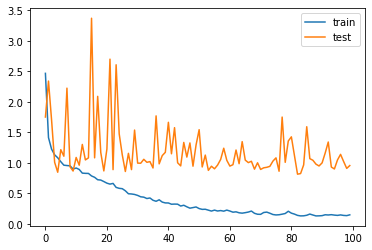

In [ ]:
import matplotlib.pyplot as plt

# plot training history
plt.plot(training_history.history['loss'], label='train')
plt.plot(training_history.history['val_loss'], label='test')
plt.legend()
plt.savefig('/content/Results/results_trainingLRN_TID2013.png')
plt.show()

# Testing step

---

PLCC  = Pearson between -1 and 1 : 0 imply no correlation at all, -1 or 1 imply  exact linear relationship

SROCC = spearmanr, same as pearson but it assume that the datasets ar normally distributed


In [ ]:
from scipy.stats import pearsonr, spearmanr

print('[INFO] Evaluating/Predicting...')

evaluation_score = model.evaluate(test_images, test_mos, batch_size=32)

predictions = model.predict(test_images, batch_size=32)

print(f'loss = {evaluation_score[0]},  accuracy = {evaluation_score[1]}')

predictions = np.squeeze(np.asarray(predictions))
test_mos = np.squeeze(np.asarray(test_mos))

plcc = pearsonr(predictions, test_mos)
srocc = spearmanr(predictions, test_mos)
print(f'PLCC = {plcc[0]}, SROCC = {srocc[0]}')

[INFO] Evaluating/Predicting...
175/175 [==============================] - 12s 47ms/step - loss: 0.9816 - rmse: 0.9908
loss = 0.9816012382507324,  accuracy = 0.9907580018043518
PLCC = 0.602622745135038, SROCC = 0.5135771599382222


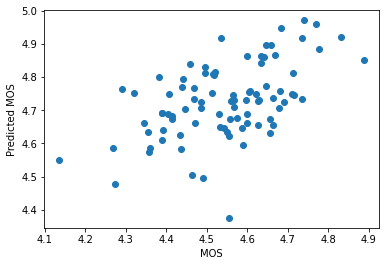

In [ ]:
# Scatter plot to vosualize the relation between the actual MOS and the 
# predicted one
test_mosMean = np.zeros((int)((len(test_mos))/64))
predictionsMean = np.zeros((int)(len(predictions)/64))
for i in range(len(test_mos)):
  if (i+1) % 64 == 0:
      test_mosMean[(int)((i+1) / 64)-1] = np.mean(test_mos[i:i+64])
for i in range(len(predictions)):
  if (i+1) % 64 == 0:
      predictionsMean[(int)((i+1) / 64)-1] = np.mean(predictions[i:i+64])
plt.scatter(test_mosMean, predictionsMean)
plt.xlabel("MOS")
plt.ylabel("Predicted MOS")
plt.savefig('/content/Results/results_testLRN_TID2013')
plt.show()